In [1]:
import numpy as np
import matplotlib.pyplot as plt
from configs import project_config
from tqdm import tqdm
import statsmodels.api as sm
from scipy.stats import norm
from joblib import Parallel, delayed
from src.classes.ClassFractionalSin import FractionalSin

In [2]:
"""def FDA_SDE_kernel(bw, x):
    return norm.pdf(x / bw) / bw

def optimise_for_betahat(path_observations, time_points, bandwidth, local_poly_smooth_order, num_paths, num_time_points):
    # Note we assume we want to estimate the drift function at the same points as the ones we observe
    assert (path_observations.shape == time_points.shape)
    assert (time_points.shape == (num_paths, num_time_points))
    # Note we assume all paths have the same number of observations and are defined on the same grid size (FOR NOW)
    assert (np.allclose(time_points, time_points[[0], :]))
    eval_time_points = time_points[0, :]
    T_data = time_points.reshape(num_paths, num_time_points, 1, 1) - time_points
    assert np.all([np.allclose(T_data[:,:, i, j], time_points-time_points[i, j]) for i in range(num_time_points) for j in range(num_time_points)])
    # Bethat is the OLS parameter vector from regression path_observations against polynomial expansion of time differences
    assert (T_data.shape == (num_paths, num_time_points, num_paths, num_time_points))
    X_data = np.stack([np.power(T_data, p) for p in range(local_poly_smooth_order+1)])
    assert (X_data.shape == (local_poly_smooth_order + 1, num_paths, num_time_points, num_paths, num_time_points))
    X_flat = X_data.reshape((X_data.shape[0], np.prod(X_data.shape[1:]))).T
    Y = np.vstack([path_observations]*(num_paths*num_time_points))
    assert (Y.shape == (num_paths*num_time_points, num_paths, num_time_points))
    Y_flat = Y.flatten()

    kernel_weights = np.sqrt(FDA_SDE_kernel(bw=bandwidth, x=T_data))
    assert (kernel_weights.shape == (num_paths, num_time_points, num_paths, num_time_points))
    betas = sm.WLS(Y_flat, X_flat, weights=kernel_weights.flatten()).fit().params.reshape(-1, 1)
    assert (betas.shape == (local_poly_smooth_order + 1, 1))
    return betas, eval_time_points

def per_t_optimise_for_betahat(path_observations, time_points, bandwidth, local_poly_smooth_order, num_paths, num_time_points):
    # Note we assume we want to estimate the drift function at the same points as the ones we observe
    assert (path_observations.shape == time_points.shape)
    assert (time_points.shape == (num_paths, num_time_points))
    # Note we assume all paths have the same number of observations and are defined on the same grid size (FOR NOW)
    assert (np.allclose(time_points, time_points[[0], :]))
    betas = np.zeros((num_time_points,local_poly_smooth_order + 1))
    eval_time_points = time_points[0, :]
    for tidx in range(num_time_points):
        t = eval_time_points[tidx]
        # Bethat is the OLS parameter vector from regression path_observations against polynomial expansion of time differences
        T_data = time_points - t
        assert (T_data.shape == (num_paths, num_time_points))
        X_data = np.stack([np.power(T_data, p) for p in range(local_poly_smooth_order+1)])
        assert (X_data.shape == (local_poly_smooth_order + 1, num_paths, num_time_points))
        X_flat = X_data.reshape((X_data.shape[0], np.prod(X_data.shape[1:]))).T
        Y_flat = path_observations.flatten()
        kernel_weights = np.sqrt(FDA_SDE_kernel(bw=bandwidth, x=T_data))
        assert (kernel_weights.shape == (num_paths, num_time_points))
        betas[tidx, :] = sm.WLS(Y_flat, X_flat, weights=kernel_weights.flatten()).fit().params
    assert (betas.shape == (num_time_points, local_poly_smooth_order + 1))
    mean_hat_t = betas[:,0]
    assert (mean_hat_t.shape == (num_time_points, ))
    delta_mean_hat_t = betas[:, 1] / bandwidth
    assert (delta_mean_hat_t.shape == (num_time_points, ))
    # 2.3: For now, we can assume the diffusion function is known for convenience (and possibly easier implementation)
    # true_cov = np.nan # TODO
    # cov_hat_t = true_cov
    return mean_hat_t,delta_mean_hat_t, eval_time_points

def estimate_drift_from_iid_paths(eval_time_points, mean_hat_t, delta_mean_hat_t, num_time_points):
    # Step 3: Plug-in estimators
    # 3.1: From Step 2, we can consistently recover the mean and covariance functions of the latent process together with their derivatives
    # 3.2: We plug these into Eq (3.5) i.e., Eq (3.14) to transform global information to local information in the form of drift and diffusion functions
    assert (eval_time_points.shape[0] == num_time_points)
    drift_hats = np.zeros((num_time_points, ))
    for tidx in range(num_time_points):
        drift_hat_t = 0. if mean_hat_t[tidx] == 0. else delta_mean_hat_t[tidx] * 1./mean_hat_t[tidx]
        drift_hats[tidx] = drift_hat_t
    return drift_hats

# Drift estimation function
def cv_nadaraya_watson_estimate_drift(x0, path, delta_X, c_const):
    h = c_const*(path.shape[0] ** (-0.2))
    path_incs = np.diff(path)
    weights = gaussian_kernel(x=(path[:-1] - x0), bw=h)
    numerator = np.sum(weights * path_incs)
    denominator = np.sum(weights)
    return numerator / (delta_X * denominator) if denominator != 0 else 0"""

'def FDA_SDE_kernel(bw, x):\n    return norm.pdf(x / bw) / bw\n\ndef optimise_for_betahat(path_observations, time_points, bandwidth, local_poly_smooth_order, num_paths, num_time_points):\n    # Note we assume we want to estimate the drift function at the same points as the ones we observe\n    assert (path_observations.shape == time_points.shape)\n    assert (time_points.shape == (num_paths, num_time_points))\n    # Note we assume all paths have the same number of observations and are defined on the same grid size (FOR NOW)\n    assert (np.allclose(time_points, time_points[[0], :]))\n    eval_time_points = time_points[0, :]\n    T_data = time_points.reshape(num_paths, num_time_points, 1, 1) - time_points\n    assert np.all([np.allclose(T_data[:,:, i, j], time_points-time_points[i, j]) for i in range(num_time_points) for j in range(num_time_points)])\n    # Bethat is the OLS parameter vector from regression path_observations against polynomial expansion of time differences\n    assert (

In [3]:
def gaussian_kernel(bw, x):
    return norm.pdf(x / bw) / bw

def rmse_ignore_nans(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

In [4]:
num_paths = 100
t0 = 0.
ts_length = 256
deltaT = 1./256
t1 = deltaT*ts_length
# Drift parameters
mean_rev = 1.
space_scale = 1.
isUnitInterval = True
diff = 1.
initial_state = 0.
rvs = None
H = 0.5

In [5]:
fSin = FractionalSin(mean_rev=mean_rev, diff=diff, X0=initial_state, space_scale=space_scale)
is_path_observations = np.array(
    [fSin.euler_simulation(H=H, N=ts_length, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=initial_state, Ms=None, gaussRvs=rvs,
                           t0=t0, t1=t1) for _ in (range(num_paths*10))]).reshape(
    (num_paths*10, ts_length+1))
is_idxs = np.arange(is_path_observations.shape[0])
path_observations = is_path_observations[np.random.choice(is_idxs, size=num_paths, replace=False),:]
# We note that we DO NOT evaluate the drift at time t_{0}=0
# We therefore remove the first element of path_observations since it includes X_{t_{0}} = X_{0}
# We also remove the last element since we never evaluate the drift at that point
t0 = deltaT
prevPath_observations = path_observations[:,1:-1]
# We compute the path incs with respect to the prevPath_observations (since X_{t_{0}} != X_{0})
path_incs = np.diff(path_observations, axis=1)[:, 1:]
assert (prevPath_observations.shape == path_incs.shape)
assert (path_incs.shape[1] == ts_length - 1)
assert (path_observations.shape[1] == prevPath_observations.shape[1] + 2)

In [6]:
def IID_NW_estimator(prevPath_observations, path_incs, bw, x, t1, t0, truncate):
    N, n = prevPath_observations.shape
    kernel_weights_unnorm = gaussian_kernel(bw=bw, x=prevPath_observations[:, :, np.newaxis] - x)
    denominator = np.sum(kernel_weights_unnorm, axis=(1,0)) / (N*n)
    numerator = np.sum(kernel_weights_unnorm * path_incs[:, :, np.newaxis], axis=(1,0)) / N*(t1 - t0)
    estimator = numerator/denominator
    # This is the "truncated" discrete drift estimator to ensure appropriate risk bounds
    if truncate:
        m = np.min(denominator)
        estimator[denominator <= m/2.] = 0.
    return estimator

In [7]:
assert (prevPath_observations.shape[1]*deltaT == (t1-t0))

In [8]:
# Note that because b(x) = sin(x) is bounded, we take \epsilon = 0 hence we have following h_max
eps = 0.
log_h_min = np.log10(np.power(float(ts_length - 1), -(1./(2.-eps))))
print(log_h_min)

-1.2032700902169775


In [9]:
def compute_cv_for_bw_per_path(i, _bw):
    N = prevPath_observations.shape[0]
    mask = np.arange(N) != i # Leave-one-out !
    estimator = IID_NW_estimator(
        prevPath_observations=prevPath_observations[mask, :],
        path_incs=path_incs[mask, :],
        bw=_bw,
        x=prevPath_observations[i, :],
        t1=t1,
        t0=t0,
        truncate = False
    )
    residual = estimator**2 * deltaT - 2 * estimator * path_incs[i, :]
    cv = np.sum(residual)
    if np.isnan(cv):
        return np.inf
    return cv

def compute_cv_for_bw(_bw):
    N = prevPath_observations.shape[0]
    #cvs = Parallel(n_jobs=4)(delayed(compute_cv_for_bw_per_path)(i, _bw) for i in (range(N)))
    cvs = [compute_cv_for_bw_per_path(i, _bw) for i in range(N)]
    return np.sum(cvs)

In [10]:
import time
bws = np.logspace(-2, -0.05, 20)
CVs = np.zeros(len(bws))
for h in tqdm(range(bws.shape[0])):
    CVs[h] = compute_cv_for_bw(bws[h])
    time.sleep(5)

100%|██████████| 20/20 [12:23<00:00, 37.17s/it]


In [11]:
bw = bws[np.argmin(CVs)]
print(CVs)
bw

[249.09363774 196.14755367 151.25350096 115.37603461  87.48522788
  64.96408813  46.17449503  30.3814128   16.90418461   5.84658
  -3.09712414 -10.61149874 -16.51520051 -20.61728499 -22.99194313
 -23.63283577 -22.58322894 -20.05429664 -16.63894496 -13.24866445]


0.3463168991269751

In [12]:
numXs = 256
Xs = np.linspace(-3, 3, numXs)
num_dhats = 500
fSin = FractionalSin(mean_rev=mean_rev, diff=diff, X0=initial_state, space_scale=space_scale)
oos_path_observations = np.array(
    [fSin.euler_simulation(H=H, N=ts_length, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=initial_state, Ms=None, gaussRvs=rvs,
                           t0=t0, t1=t1) for _ in (range(num_paths*10))]).reshape(
    (num_paths*10, ts_length+1))
idxs = np.arange(oos_path_observations.shape[0])

unif_is_drift_hats = np.zeros((numXs, num_dhats))
unif_oos_drift_hats = np.zeros((numXs, num_dhats))

for k in tqdm(range(num_dhats)):
    oos_ss_path_observations = oos_path_observations[np.random.choice(idxs, size=num_paths, replace=False),:]
    oos_prevPath_observations = oos_ss_path_observations[:,1:-1]
    oos_path_incs = np.diff(oos_ss_path_observations, axis=1)[:, 1:]
    unif_oos_drift_hats[:,k] = IID_NW_estimator(prevPath_observations=oos_prevPath_observations, bw=bw, x=Xs, path_incs=oos_path_incs, t1=t1, t0=t0, truncate=True)
    is_ss_path_observations = is_path_observations[np.random.choice(idxs, size=num_paths, replace=False),:]
    is_prevPath_observations = is_ss_path_observations[:,1:-1]
    is_path_incs = np.diff(is_ss_path_observations, axis=1)[:, 1:]
    unif_is_drift_hats[:, k] = IID_NW_estimator(prevPath_observations=is_prevPath_observations, bw=bw, x=Xs, path_incs=is_path_incs, t1=t1, t0=t0, truncate=True)

100%|██████████| 500/500 [05:40<00:00,  1.47it/s]


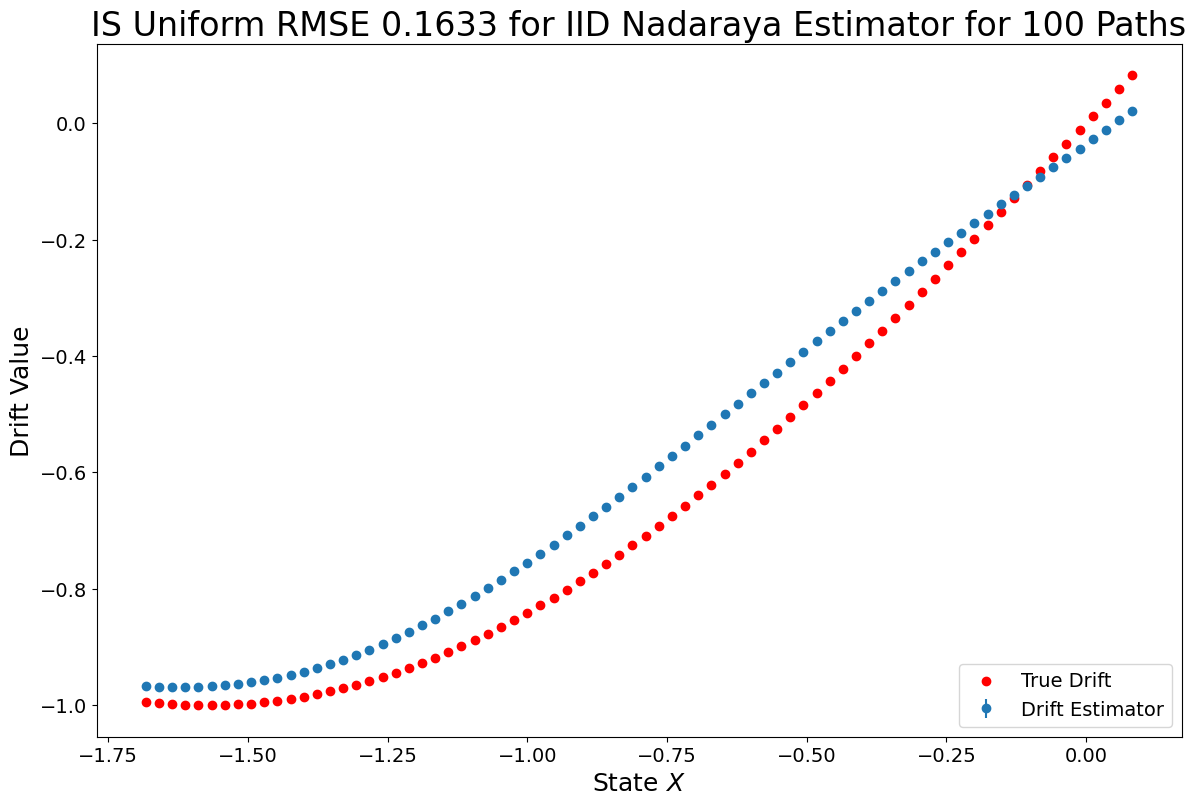

0.16328686812822726


In [26]:
fig, ax = plt.subplots(figsize=(14, 9))
true_drift = mean_rev*np.sin(space_scale*Xs.flatten())
mean_drift_hats = np.mean(unif_is_drift_hats, axis=1)
rmse = rmse_ignore_nans(mean_drift_hats, true_drift)
std = 0*np.std(unif_is_drift_hats, axis=1)
true_drift[Xs < -1.7] = np.nan
true_drift[Xs > 0.1] = np.nan
mean_drift_hats[Xs < -1.7] = np.nan
mean_drift_hats[Xs > 0.1] = np.nan
plt.scatter(Xs, true_drift, color="red", label="True Drift")
plt.errorbar(Xs, mean_drift_hats,fmt="o", yerr=2*std, label="Drift Estimator")
ax.set_title(rf"IS Uniform RMSE {round(rmse, 4)} for IID Nadaraya Estimator for {num_paths} Paths", fontsize=24)
ax.tick_params(labelsize=14)
plt.ylabel("Drift Value", fontsize=18)
plt.xlabel(r"State $X$", fontsize=18)
ax.legend(loc="lower right", fontsize=14)
plt.show()
plt.close()
print(rmse)

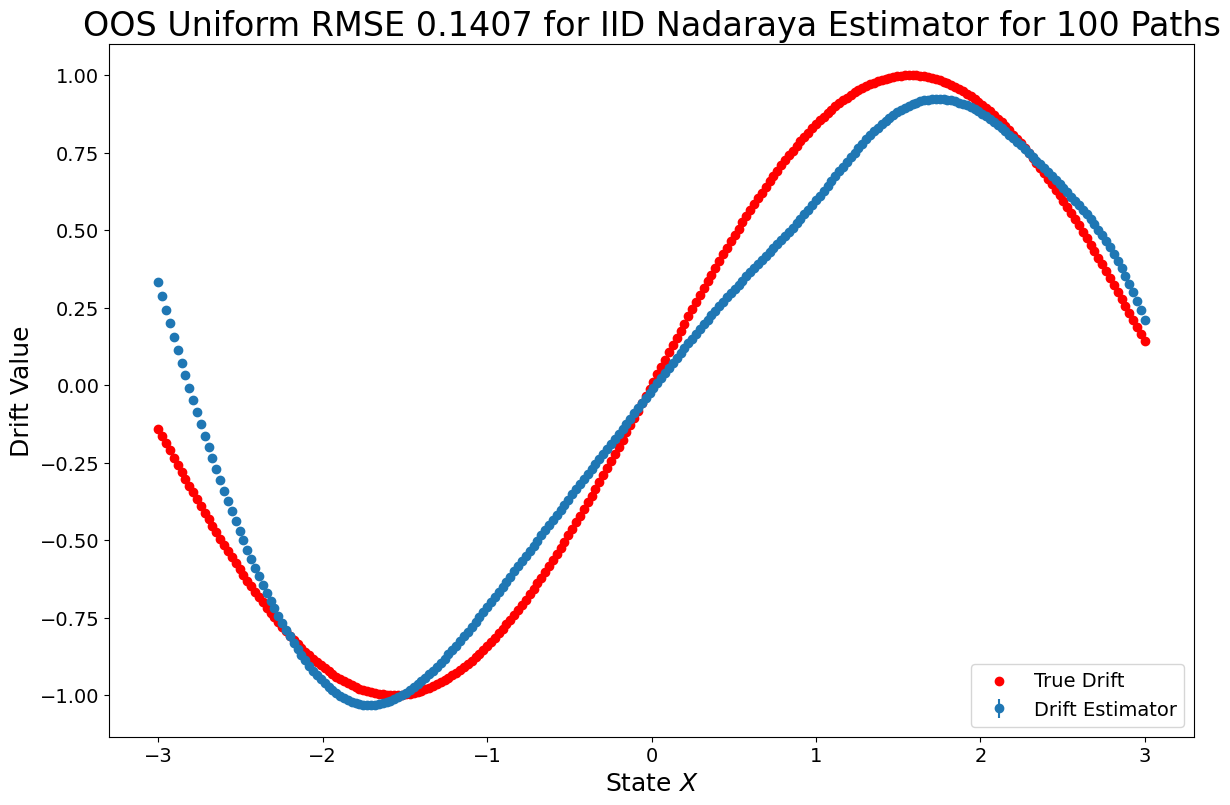

0.14065519403403642


In [28]:
fig, ax = plt.subplots(figsize=(14, 9))
true_drift = mean_rev*np.sin(space_scale*Xs.flatten())
mean_drift_hats = np.mean(unif_oos_drift_hats, axis=1)
rmse = rmse_ignore_nans(mean_drift_hats, true_drift)
std = 0*np.std(unif_oos_drift_hats, axis=1)
#true_drift[Xs < -1.7] = np.nan
#true_drift[Xs > 0.1] = np.nan
#mean_drift_hats[Xs < -1.7] = np.nan
#mean_drift_hats[Xs > 0.1] = np.nan
plt.scatter(Xs, true_drift, color="red", label="True Drift")
plt.errorbar(Xs, mean_drift_hats,fmt="o", yerr=2*std, label="Drift Estimator")
ax.set_title(rf"OOS Uniform RMSE {round(rmse,4)} for IID Nadaraya Estimator for {num_paths} Paths", fontsize=24)
ax.tick_params(labelsize=14)
plt.ylabel("Drift Value", fontsize=18)
plt.xlabel(r"State $X$", fontsize=18)
ax.legend(loc="lower right", fontsize=14)
plt.show()
plt.close()
print(rmse)